In [1]:
import sys
sys.path.append("../") # go to parent dir

import jax
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt
import module.chebyshev_solver as chb

import optax
from tqdm import tqdm
key = jax.random.PRNGKey(5)

from scipy.optimize import curve_fit

## Idea
In this notebook we want to investigate the dependence of the error of the inferred conductivity k on the number of imposed measurements. Therefore,
we generate a condictivity k and infer k by including different amounts of measurements (meaning pairs of dirichlet and neumann pairs). This analysis can be done for different grid sizes. It is found that the error decreases with the number of measurements.

In [2]:
Ns = jnp.arange(1, 11)
n_k_init = 10

In [3]:
solver = chb.Solver(N = 20)
xx = solver.xx
yy = solver.yy
grid = solver.grid
dims = (solver.N, solver.N)
mask = np.ones(dims)
mask[1:-1,1:-1] = 0
maskx = np.ones(dims)
maskx[:,1:-1] = 0
masky = np.ones(dims)
masky[1:-1,:] = 0
mask = jnp.array(mask)
ii, jj = jnp.meshgrid(jnp.arange(solver.N), jnp.arange(solver.N))
a = 1.4
index_decay = jnp.exp(-(ii+jj)/a)

res_maxs = []
res_means = []

for m in range(n_k_init):
    k_cheby_init = jax.random.normal(key, shape = dims) * index_decay
    k_cheby_init = k_cheby_init.at[0,0].set(k_cheby_init[0,0] + jnp.sum(index_decay)*2)
    k_cheby_init = k_cheby_init.flatten()
    k_init = (solver.I @ k_cheby_init).reshape(dims)

    maxs = []
    means = []

    for N in Ns:
        N_measure = N
        measurements = []
        for i in range(N_measure):
            key, _ = jax.random.split(key)

            dirichlet_cheby = jax.random.normal(key, shape = dims) * index_decay
            dirichlet = (solver.I @ dirichlet_cheby.flatten()).reshape(dims)
            dirichlet *= mask

            sol = solver.solve(k_cheby_init, dirichlet)

            measurements.append((dirichlet, sol))

        @jax.jit
        def get_neumann(solution):
            jx = (solution["dx T"] * solution["k"]).reshape(dims)
            jy = (solution["dy T"] * solution["k"]).reshape(dims)

            neumann = jnp.concatenate((jx[:,0], jy[-1,:], jx[:,-1], jy[0,:]), axis = 0)
            return neumann

        @jax.jit
        def distance(solution, target_solution):
            neumann = get_neumann(solution)
            target_neumann = get_neumann(target_solution)

            return jnp.sum((neumann - target_neumann)**2)

        @jax.jit
        def get_solution(k_param, dirichlet):
            k_cheby = k_param["coeff"] * index_decay
            k_cheby = k_cheby.flatten()
            solution = solver.solve(k_cheby, dirichlet)
            return solution


        @jax.jit
        def get_solution_internal(k_cheby_flat, dirichlet):
            solution = solver.solve(k_cheby_flat, dirichlet)
            return solution
        ## 3. Optimize parameters
        @jax.jit
        def loss(k_param):
            acc = 0
            for i in range(N_measure):
                acc += distance(get_solution(k_param, measurements[i][0]), measurements[i][1])
            return acc

        @jax.jit
        def loss_internal(k_cheby_flat):
            acc = 0
            for i in range(N_measure):
                acc += distance(get_solution_internal(k_cheby_flat, measurements[i][0]), measurements[i][1])
            return acc
        
        
        ## 2. Initialise variational parameters
        key, _ = jax.random.split(key)
        k_cheby = jax.random.normal(key, shape = dims) * index_decay
        k_cheby = k_cheby.at[0,0].set(k_cheby[0,0] + jnp.sum(index_decay))
        k_param = {"coeff":k_cheby}


        g = jax.value_and_grad(loss)
        h = jax.hessian(loss_internal)
        # define
        optimizer = optax.sgd(learning_rate=0.0003)

        # initialise
        optimizer_state = optimizer.init(k_param)

        err = []
        for i in tqdm(range(2000)):
            val, grad = g(k_param)
            err.append(val)

            updates, optimizer_state = optimizer.update(grad, optimizer_state, k_param)

            k_param = optax.apply_updates(k_param, updates)

        result = get_solution(k_param, measurements[0][0])
        max = jnp.max(jnp.abs(result["k"].reshape(dims) / (measurements[0][1]["k"].reshape(dims)) - 1))
        maxs.append(np.array(max))
        mean = jnp.mean(jnp.abs(result["k"].reshape(dims) / (measurements[0][1]["k"].reshape(dims)) - 1))
        means.append(np.array(mean))


    res_maxs.append(maxs)
    res_means.append(means)

100%|██████████| 2000/2000 [10:57<00:00,  3.04it/s]


In [4]:
res_maxs = np.array(res_maxs)
res_means = np.array(res_means)

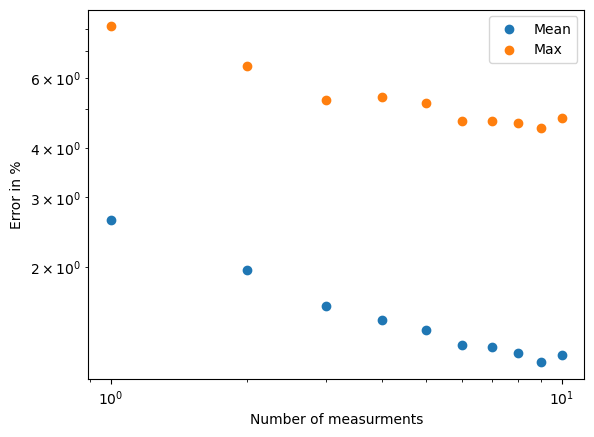

In [5]:
means = np.mean(res_means*100, axis = 0)
maxs = np.mean(res_maxs*100, axis = 0)

plt.scatter(Ns, means,label = "Mean")
plt.yscale("log")
plt.xscale("log")
plt.scatter(Ns, maxs,label="Max")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Error in %")
plt.xlabel("Number of measurments")
plt.legend()

#This might have to do something with central limit theorem


In [6]:
def f(x, a, b):
    return a* x + b 

res_means_fit = curve_fit(f, np.log(Ns), np.log(means))
res_maxs_fit = curve_fit(f, np.log(Ns), np.log(maxs))

[-0.24098353  2.02664475]
[-0.35152715  0.91196044]


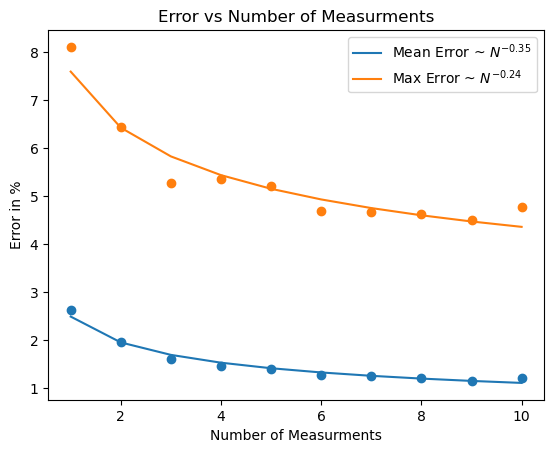

In [8]:

plt.title('Error vs Number of Measurments')
plt.plot(Ns,np.e**f(np.log(Ns),res_means_fit[0][0],res_means_fit[0][1]),label='Mean Error ~ $N^{-0.35}$')
plt.scatter(Ns,means)
plt.plot(Ns,np.e**f(np.log(Ns),res_maxs_fit[0][0],res_maxs_fit[0][1]),label = 'Max Error ~ $N^{-0.24}$')
plt.scatter(Ns,maxs)
plt.legend()
plt.ylabel('Error in %')
plt.xlabel('Number of Measurments')
print(res_maxs_fit[0])
print(res_means_fit[0])
plt.savefig("../plot/ErrFor20x20Measurments.pdf")